In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import pandas as pd
import sys
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
def get_prob_maps_list(prob_map):
    num_classes = 13
    probs_list = []

    for i in prob_map.items():

        for label in range(num_classes):
            probs_list.append(i[1][label][0])

    prob_img = np.zeros((num_classes, 691, 691))
    _, rows, cols = prob_img.shape

    for i in range(rows):
        for j in range(cols):

            prob_img[:, i, j] = np.array([probs_list[label][i, j] for label in range(num_classes)])

    return prob_img

In [3]:
def calculate_ece(y_true, y_pred, probs, num_bins=10):
        
    correct = (y_pred == y_true.astype(np.float32))

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    bins = np.digitize(probs, bins=b, right=True)

    o = 0
    for b in range(num_bins):
        mask = bins == b
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - probs[mask]))

    ece = o / y_pred.shape[0]

    x = probs[mask]
    y = correct[mask]

    return x, y, ece

In [4]:
def reliability_diagram(x, y):

    #plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.hist(x, y, "s-", label="nnU-Net")

    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.title("Reliability diagram / calibration curve")

    plt.tight_layout()
    plt.show()

Checking  ESTNEMC0027_1_frame160_001.npz ESTNEMC0027_1_frame160_001.nii.gz


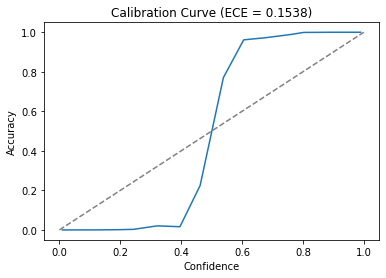

Checking  ESTNEMC0027_1_frame19_001.npz ESTNEMC0027_1_frame19_001.nii.gz
no lipid
Checking  ESTNEMC0027_1_frame200_001.npz ESTNEMC0027_1_frame200_001.nii.gz
no lipid
Checking  ESTNEMC0027_1_frame230_001.npz ESTNEMC0027_1_frame230_001.nii.gz


KeyboardInterrupt: 

In [44]:
preds_path = r'Z:\grodriguez\CardiacOCT\preds_second_split\model_rgb_2d_preds'
orig_path = r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task602_CardiacOCT\labelsTs'

num_bins = 15

preds_list = os.listdir(preds_path)
orig_list = os.listdir(orig_path)

for orig in orig_list[4:]:

    frame_name = orig.split('.')[0]
    files_for_frame = []

    for pred in preds_list:
        
        if frame_name in pred:
            files_for_frame.append(pred)

    npz_file = [npz for npz in files_for_frame if npz.endswith('npz')][0]
    nifti_file = [nifti for nifti in files_for_frame if nifti.endswith('nii.gz')][0]

    print('Checking ', npz_file, nifti_file)
    pred_seg = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\preds_second_split\model_rgb_2d_preds\{}'.format(nifti_file))
    pred_seg_data = sitk.GetArrayFromImage(pred_seg)[0]
    orig_seg = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task602_CardiacOCT\labelsTs\{}'.format(nifti_file))
    orig_seg_data = sitk.GetArrayFromImage(orig_seg)[0]
    prob_map = np.load(r'Z:\grodriguez\CardiacOCT\preds_second_split\model_rgb_2d_preds\{}'.format(npz_file))
    
    prob_img = get_prob_maps_list(prob_map)

    true_seg_crop = orig_seg_data[6:697, 6:697]
    pred_seg_crop = pred_seg_data[6:697, 6:697]


    true_lipid_crop = true_seg_crop[true_seg_crop == 4]
    pred_lipid_crop = pred_seg_crop[true_seg_crop == 4]
    prob_lipid_img = prob_img[4][true_seg_crop == 4]

    correct = (pred_lipid_crop == true_lipid_crop.astype(np.float32))

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    bins = np.digitize(prob_lipid_img, bins=b, right=True)

    ece = 0
    x = []
    y = []
    for i in range(num_bins):
        mask = bins == i

        if np.any(mask):

            correct_predictions = sum(pred_lipid_crop[mask][i] == true_lipid_crop[mask][i] for i in range(len(pred_lipid_crop[mask])))
            accuracy = correct_predictions / len(pred_lipid_crop[mask])
            conf = np.mean(prob_lipid_img[mask])
            ece += len(prob_lipid_img[mask])/pred_lipid_crop.shape[0] * np.abs(accuracy - conf)

            y.append(accuracy)
            x.append(conf)
    
    if ece == 0:
        print('no lipid')
        continue

    #x, y, ece = calculate_ece(true_lipid_crop, pred_lipid_crop, prob_lipid_img, 20)
    width = (b[1] - b[0]) * 0.8  # Adjust the width of each bar
    # width=width, align='center', edgecolor='black'
    bin_centers = b[:-1] + (b[1] - b[0]) / 2  # Compute the centers of each bin
    plt.plot(x, y)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(f'Calibration Curve (ECE = {ece:.4f})')
    #plt.xticks(b[:-1], [f'{b[i]:.1f}-{b[i+1]:.1f}' for i in range(num_bins-1)])  # Set the tick labels
    plt.show()